In [21]:
from mobile_sam import SamAutomaticMaskGenerator
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [63]:
FILEPATH = "circle.jpg"
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [19]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=40)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Both `max_new_tokens` (=40) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the baptism of jesus, from the bibliothèque nationale de france


In [45]:
prompt = "Question: What people or objects or events are present in the image? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The mona lisa


In [64]:
import sys
sys.path.insert(1, 'GroundingDINO')
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [65]:
model = load_model("./GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "./weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


In [66]:
import os
import supervision as sv

# TEXT_PROMPT = "person . saint . soldier . shield . halo . whip"
TEXT_PROMPT = "object . person"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25

image_source, image = load_image(FILEPATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_THRESHOLD, 
    text_threshold=TEXT_THRESHOLD,
    device="cpu"
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [67]:
print(boxes)
x_center = (boxes[:, 0] + boxes[:, 2]) / 2
y_center = (boxes[:, 1] + boxes[:, 3]) / 2
centers = np.stack([x_center, y_center], axis=1)

tensor([[0.4868, 0.4980, 0.7863, 0.8487]])


In [68]:
centers

array([[0.6365382, 0.6733942]], dtype=float32)

In [70]:
centers_pixel = centers.copy()
centers_pixel[:, 0] *= 818
centers_pixel[:, 1] *= 800

In [73]:
centers_pixel
phrases

['object']

In [72]:
image.shape

torch.Size([3, 800, 864])

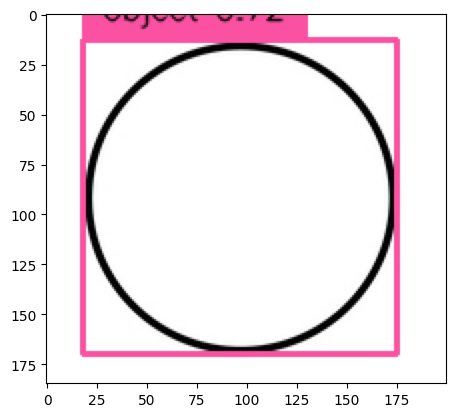

In [69]:
plt.imshow(annotated_frame)